# Import thư viện

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import copy
from re import sub
from decimal import Decimal
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas
from dataprep.clean import clean_country

pd.set_option('display.max_columns', None)


# Preprocess


In [2]:
def curr_to_dec(money):
    return float(sub(r'[^\d.]', '', money))
def gdp_preproc(gdp_df):
    gdp_df = gdp_df[['GDP (nominal, 2017)','GDP per capita','Country']]
    gdp_df['GDP (nominal, 2017)'] = gdp_df['GDP (nominal, 2017)'].apply(curr_to_dec)
    gdp_df['GDP per capita'] = gdp_df['GDP per capita'].apply(curr_to_dec)
    gdp_df = clean_country(gdp_df,"Country",output_format="alpha-3")
    return gdp_df
def preproc_col(df):
    return df.rename(columns={"Country,Other":"Country"}).drop(columns=['Unnamed: 0'])
def merge_gdp(df,gdp_df=pd.read_csv("./data/gdp.csv")):
    return gdp_preproc(gdp_df).merge(df,on='Country_clean')
def add_death_per_cases(df):
    df['Deaths/Cases'] = df['TotalDeaths']/df['TotalCases']
    return df
def _preproc(df):
    result = copy.deepcopy(df)
    result = result.drop(df.tail(8).index)    
    result = preproc_col(result)
    result = add_death_per_cases(result)
    result = clean_country(result,"Country",output_format="alpha-3")
    result = result.drop(columns=['Country'])
    result = merge_gdp(result)
    return result.rename(columns={"Country_clean":"CODE"})

In [3]:
df = pd.read_csv('./data/2022-04-27.csv')
df = _preproc(df)
df = df.dropna(axis=0,subset=['Deaths/1M pop','Tot\xa0Cases/1M pop'])

  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	221 values cleaned (93.64%)
	13 values unable to be parsed (5.51%), set to NaN
Result contains 222 (94.07%) values in the correct format and 14 null values (5.93%)


/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	190 values cleaned (100.0%)
Result contains 190 (100.0%) values in the correct format and 0 null values (0.0%)


# Vẽ bản đồ dựa vào cột

In [4]:
def world_map_visualize(df,column,_cmap="Reds"):
    # first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    # rename the columns so that we can merge with our data
    world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
    # then merge with our data 
    merge=pd.merge(world,df,on='CODE')
    # last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
    location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
    merge=merge.merge(location,on='name')
    # plot confirmed cases world map 
    merge.plot(column=column, scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap=_cmap)
    plt.title(column)

    # add countries names and numbers 
    
    plt.show()

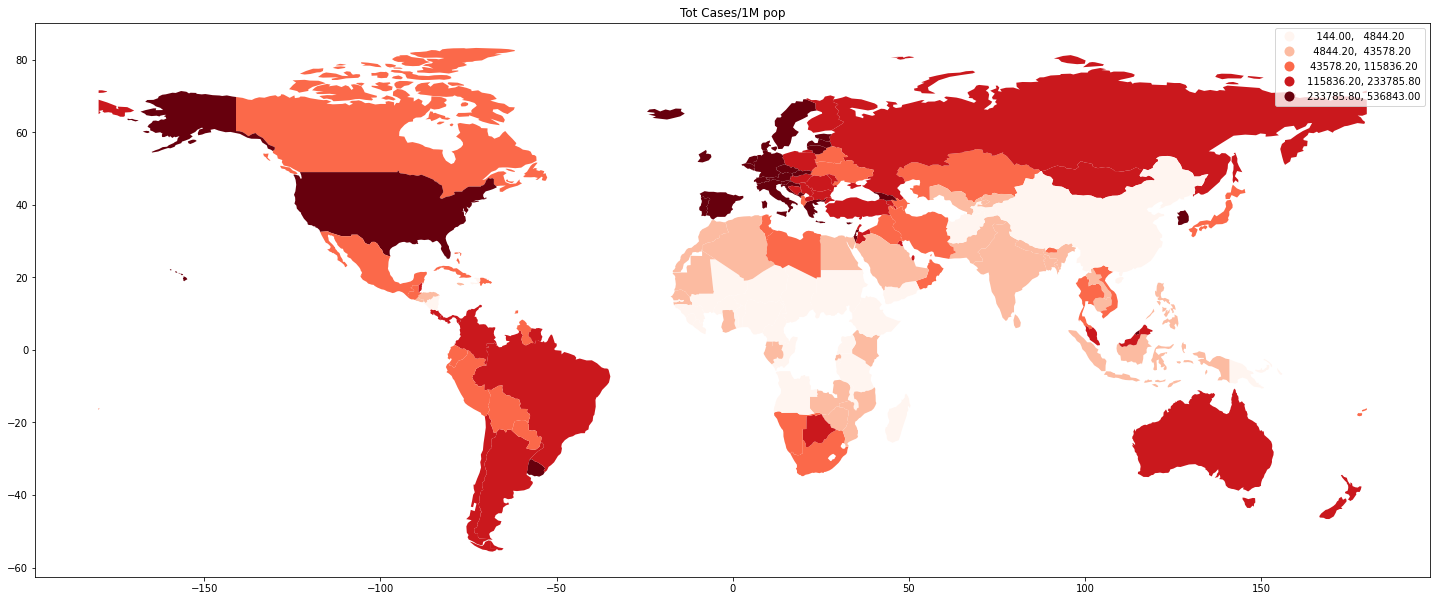

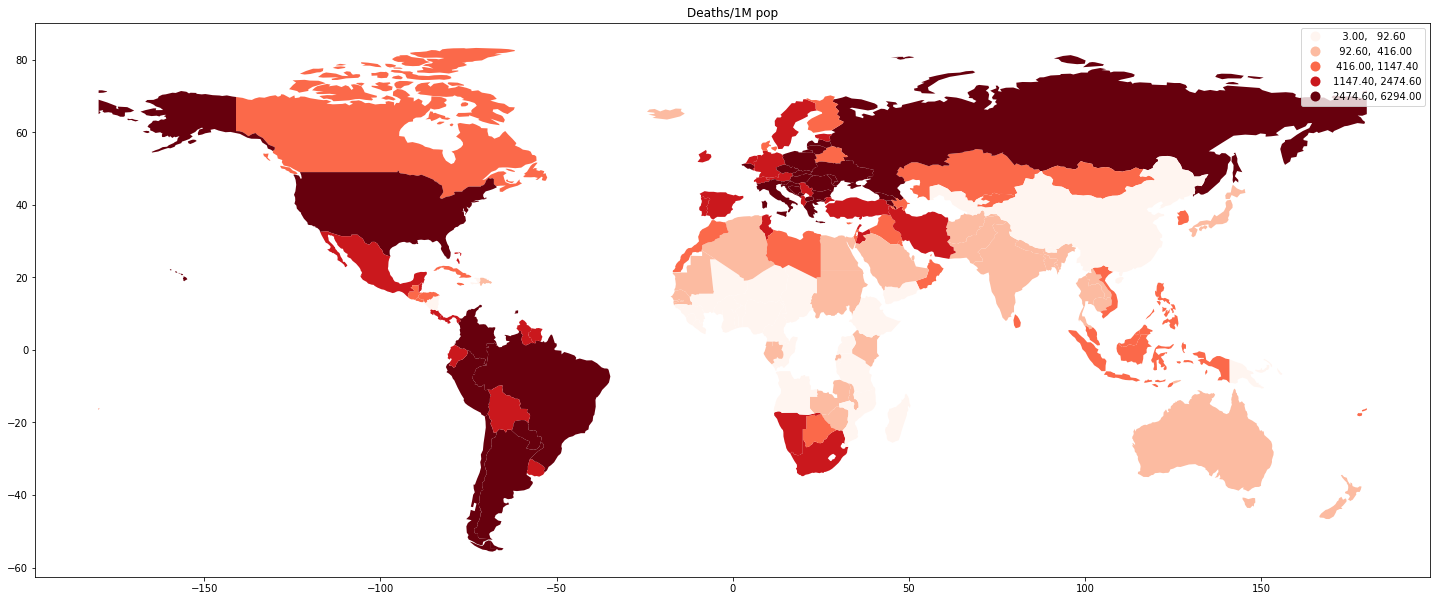

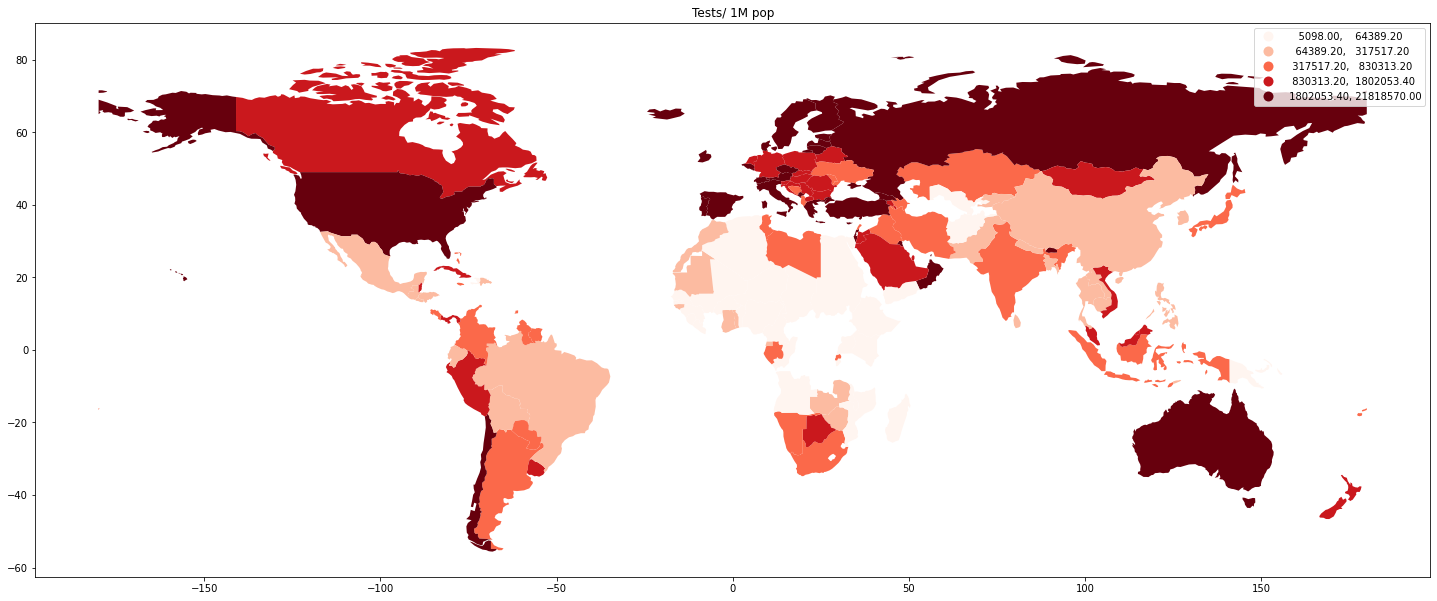

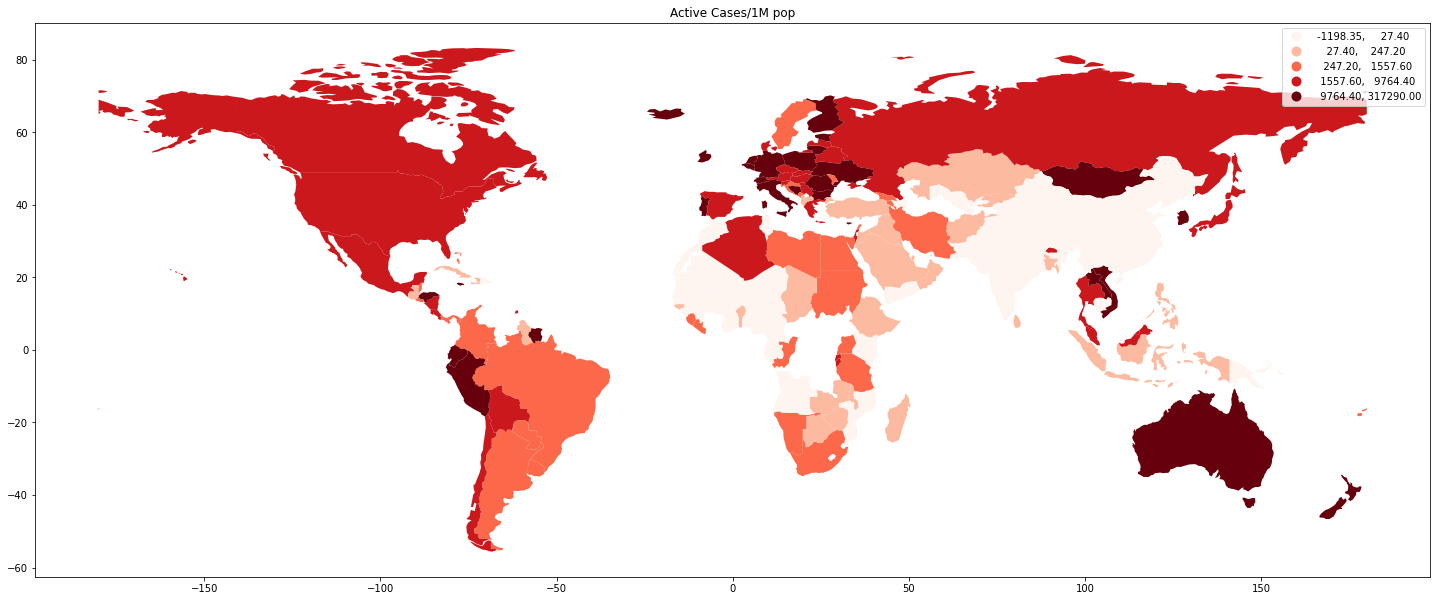

In [5]:
for col in ['Tot\xa0Cases/1M pop','Deaths/1M pop', 'Tests/ 1M pop','Active Cases/1M pop']:
    world_map_visualize(df,col)

# Tương quan giữa tỉ lệ nhiễm và tỉ lệ tử vong

<AxesSubplot:xlabel='Tot\xa0Cases/1M pop', ylabel='Deaths/Cases'>

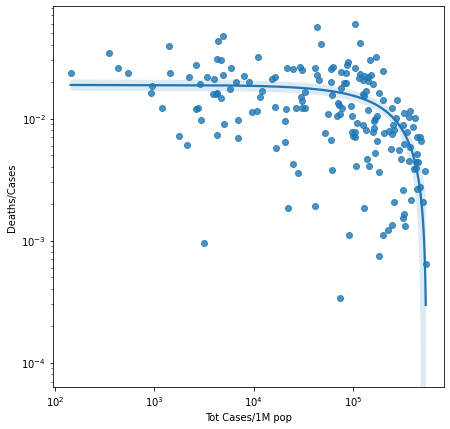

In [6]:
df_1 = copy.deepcopy(df)
# bỏ 2 dòng outlier (theo quan sát bằng mắt)
df_1 = df_1.drop(df_1['Deaths/Cases'].idxmax())
df_1 = df_1.drop(df_1['Deaths/Cases'].idxmax())

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="symlog",yscale='log')

sns.regplot(x='Tot\xa0Cases/1M pop', y='Deaths/Cases', data=df_1,ax = ax)

In [7]:
Y = stats.zscore(df['Deaths/Cases'])
X = stats.zscore(df['Tot\xa0Cases/1M pop'])
model_OLS = sm.OLS(Y,X)
result_OLS = model_OLS.fit()
result_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Deaths/Cases   R-squared (uncentered):                   0.124
Model:                            OLS   Adj. R-squared (uncentered):              0.119
Method:                 Least Squares   F-statistic:                              25.14
Date:                Tue, 03 May 2022   Prob (F-statistic):                    1.29e-06
Time:                        15:18:46   Log-Likelihood:                         -240.75
No. Observations:                 178   AIC:                                      483.5
Df Residuals:                     177   BIC:                                      486.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Tot Cases/1M pop    -0.3527      0.070     -5.014      0.000      -0.491      -0.214
==============================================================================
Omnibus:                      255.541   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23961.595
Skew:                           6.102   Prob(JB):                         0.00
Kurtosis:                      58.514   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Tot\xa0Cases/1M pop'>

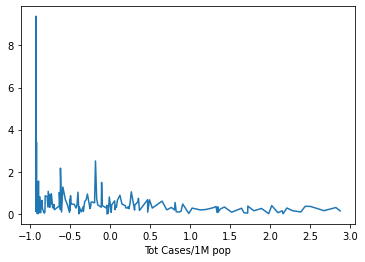

In [8]:
Y_pred = result_OLS.predict(X)
_std = np.sqrt((Y-Y_pred)**2)
sns.lineplot(x = X,y = _std)

# Gom nhóm các nước có dữ liệu giống nhau và trực quan trên bản đồ

In [9]:
from sklearn.cluster import KMeans
X = df[["Deaths/Cases","TotalCases"]]
kmeans = KMeans(n_clusters=7).fit(X)
df['label'] = kmeans.labels_

/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


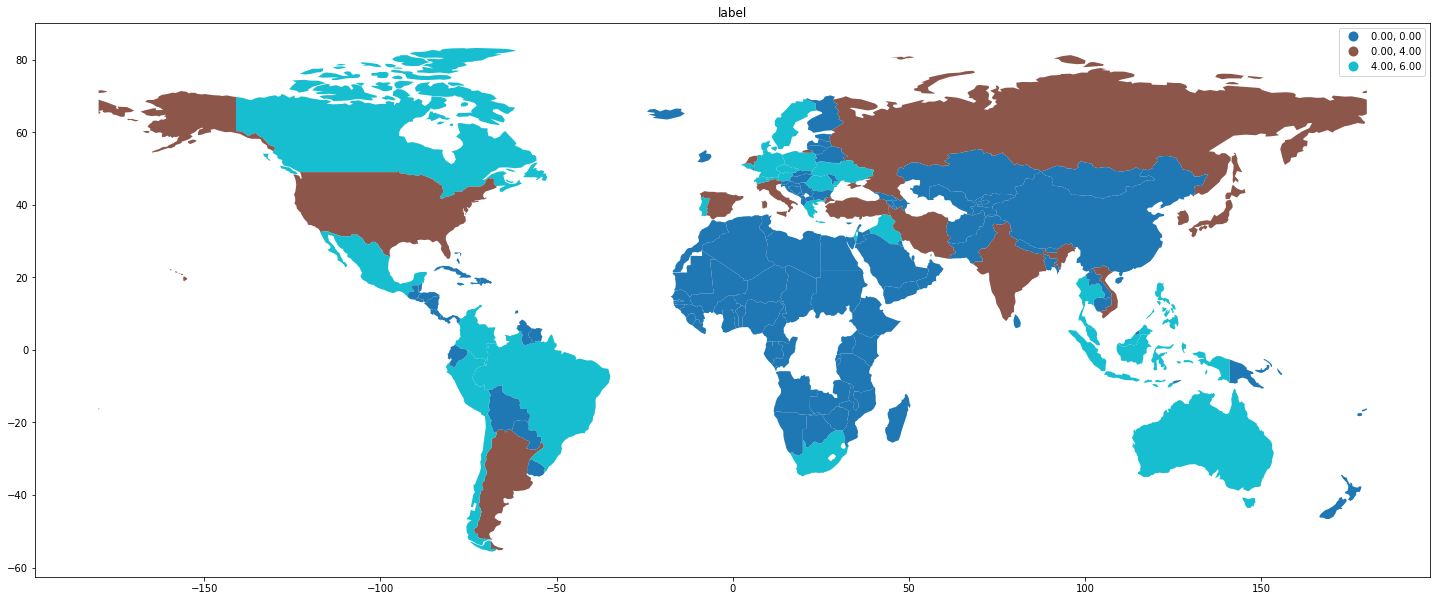

In [10]:
# plot confirmed cases world map 
world_map_visualize(df,'label','tab10')

# Trực quan giữa (GDP - tỉ lệ tử vong) và (GDP - tỉ lệ mắc)

<AxesSubplot:xlabel='GDP (nominal, 2017)', ylabel='Tot\xa0Cases/1M pop'>

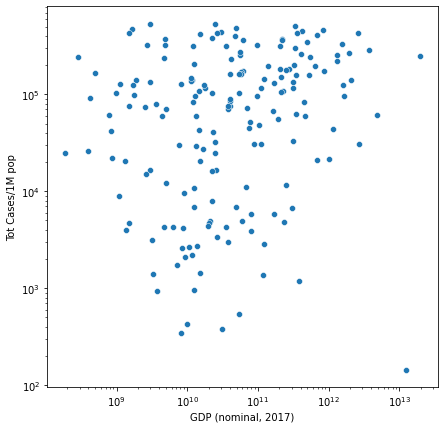

In [11]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='GDP (nominal, 2017)', y='Tot\xa0Cases/1M pop', data=df,ax = ax)

<AxesSubplot:xlabel='GDP (nominal, 2017)', ylabel='Deaths/Cases'>

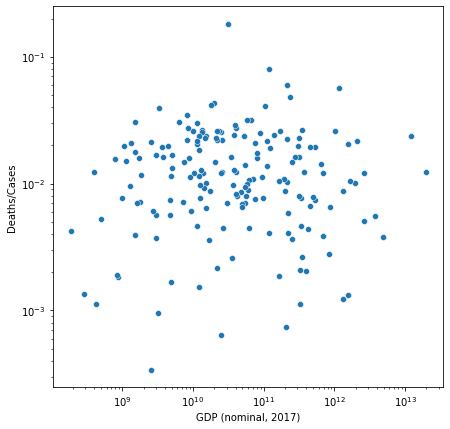

In [13]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='GDP (nominal, 2017)', y='Deaths/Cases', data=df,ax = ax)

# Số lượng Test nhiều sẽ dẫn đến số lượng mắc Covid nhiều hay không

Ngay trong đại dịch, có ý kiến cho rằng chỉ cần giờ chúng ta ít test lại thì sẽ không phát hiện nhiều case mới, liệu điều này có đúng hay không, thì đây là biểu đồ thể hiện sự quan hệ giữa tổng số ca nhiễm và tổng số mẫu test đã thực hiện dựa trên báo cáo:
Có thể thấy rằng:
* Có vài trường hợp đặc biệt khi các nước test quá nhiều $\rightarrow$ giải quyết bằng cách đưa về đồ thị dạng $\text{log-scale}$
* Sau khi đưa về ta thấy được một mối quan hệ khá là đẹp, dữ liệu gần như tuyến tính, vậy cũng có thể kết luận rằng nếu làm càng nhiều test thì phát hiện được nhiều ca nhiễm hơn

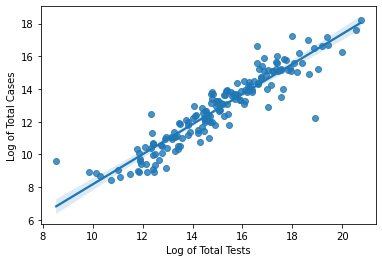

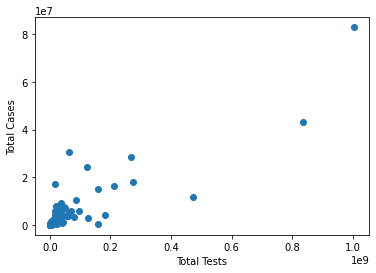

In [14]:
def _visualize_Ntest_and_Ncases(df):
    """
    
    N_tests_fig = plt.figure()
    N_tests_ax = N_tests_fig.add_subplot()
    N_tests_ax.hist(N_tests_dropna)
    N_tests_ax.set(xscale="log")
    N_tests_fig.show()
    """
    Ntests_and_Ncases = df[['TotalCases','TotalTests',"CODE"]]
    Ntests_and_Ncases_dropna = Ntests_and_Ncases.dropna()
    fig = plt.figure()
    fige = plt.figure()
    ax = fig.add_subplot()
    axe = fige.add_subplot()
    
    axe.set( xlabel="Total Tests", ylabel="Total Cases")
    axe.scatter(Ntests_and_Ncases_dropna['TotalTests'].to_list(), Ntests_and_Ncases_dropna['TotalCases'].to_list())
    ax.set(xlabel="Log of Total Tests", ylabel="Log of Total Cases")
    sns.regplot(x = np.log(Ntests_and_Ncases_dropna['TotalTests'].to_list()), y = np.log(Ntests_and_Ncases_dropna['TotalCases'].to_list()), ax = ax)
    #return Ntests_and_Ncases_dropna
_visualize_Ntest_and_Ncases(df)

In [15]:
CONTINENT = df['Continent'].unique()
CONTINENT

array(['North America', 'Asia', 'Europe', 'South America',
       'Australia/Oceania', 'Africa'], dtype=object)

{'TotalDeaths': {'North America': 1455836.0, 'Asia': 1416093.0, 'Europe': 1639255.0, 'South America': 1287776.0, 'Australia/Oceania': 9495.0, 'Africa': 249619.0}, 'TotalCases': {'North America': 97674185, 'Asia': 146454949, 'Europe': 168001343, 'South America': 56138261, 'Australia/Oceania': 6863541, 'Africa': 11302273}, 'ActiveCases': {'North America': 2277012.0, 'Asia': 3141766.0, 'Europe': 9691055.0, 'South America': 487309.0, 'Australia/Oceania': 403042.0, 'Africa': 391354.0}}
TotalDeaths of the whole world: 6058074.0
TotalCases of the whole world: 486434552
ActiveCases of the whole world: 16391538.0


/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


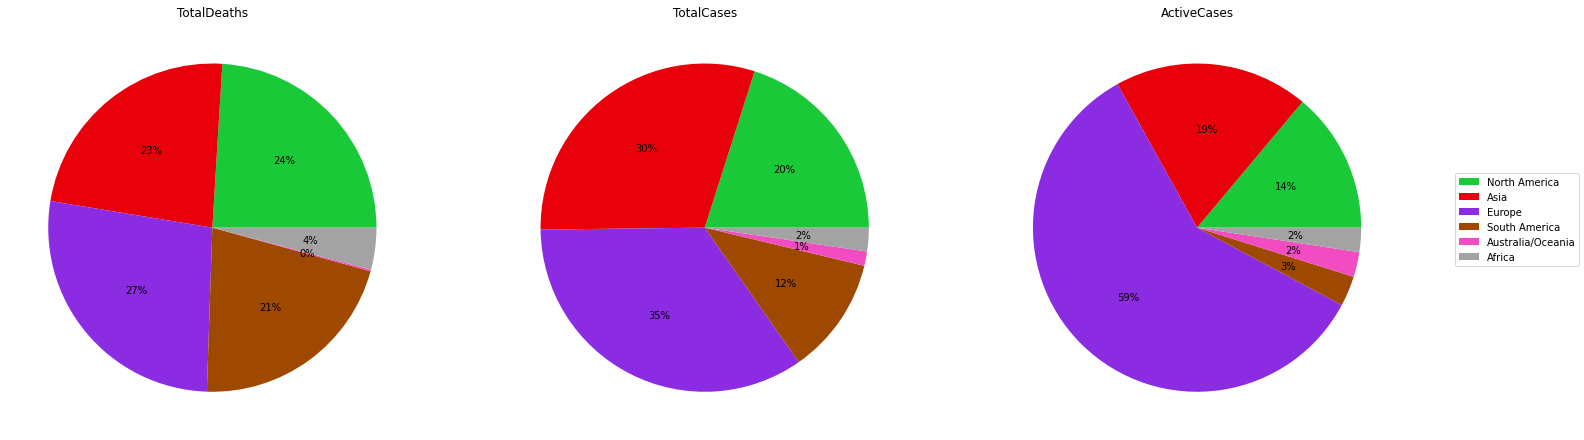

In [16]:
def _circular_percentage_death(df, continents, columns = ["TotalDeaths"]):
    dic = {}
    for k in columns:
        dic.update({k: {}})
    def _update_xs_of_continents(df,dic,continent, column):
        filt = df["Continent"] == continent
        continent_total_x = (df[filt])[column].sum()
    #    print(continent_total_deaths)
        dic[column].update({continent: continent_total_x})
        return dic
    
    
    # Using above function using for loop
    for conti in continents:
        for col in columns:
            dic = _update_xs_of_continents(df, dic, conti, col)
    print(dic)
    #for k,v in dic:
    #    print(k,v)
    data = {}
    labels = {}
    #plt.style.use('ggplot')
    for col in columns:
        
        sum_ = sum([v for k,v in dic[col].items()])
        print(f"{col} of the whole world: {sum_}")
    
    #define data
        data[col] = [v for k,v in dic[col].items()]
        labels[col] = [k for k in dic[col]]

    #def ine Seaborn color palette to use
    colors = sns.color_palette('bright')[2:8]
    fig, ax = plt.subplots(ncols=len(columns),figsize=(25,25),squeeze=False)
    for i in range(len(columns)):
        col = columns[i]
        dn = ax[0,i].pie(data[col], colors=colors, autopct='%.0f%%')
        ax[0,i].set(ylabel='', title=col, aspect='equal')
    #create pie chart
    #fig.figsize((15,15))
    #ax.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    fig.legend(dn[0],continents,loc="right")
    fig.show()
_circular_percentage_death(df, CONTINENT, columns= ["TotalDeaths", "TotalCases","ActiveCases"])
        